
<br>
<font>
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Machine Learning <br> <br>
<font color=2565AE size=5>
    CE Department <br>
    Fall 2024 - Prof. Sharifi Zarchi<br>
<font color=3C99D size=5>
    HW4 Practical <br>
    Image Colorization<br>
    Image Segmentation<br>
<font color=696880 size=4>
    Shayan Shabani


In [5]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


This assignment is structured to introduce students to practical applications of generative models in computer vision.
It targets two challenging areas: colorization and segmentation, using architectures that are complex but very applicable in industry settings.
## Machine Learning Assignment #4: Practical Applications in Image Processing

## Learning Objectives:
By the end of this assignment, students will be able to:
1. Understand and implement Variational Autoencoders for image colorization.
2. Apply the U-Net architecture for image segmentation.
3. Preprocess image datasets, including augmentation techniques.
4. Analyze the performance of machine learning models using relevant metrics.
5. Explore the relationship between latent space and output quality in generative models.


# Image Colorization using VAE
In this section of the assignment, students will explore the fascinating field of image colorization using Variational Autoencoders (VAEs), a type of generative model in deep learning. The task involves transforming grayscale images into colored ones, leveraging the encoder-decoder architecture of VAEs, which are adept at learning complex data distributions. Students will implement and fine-tune an autoencoder network, utilizing components like perceptual loss and feature extraction from pre-trained models, to improve colorization output. By doing so, they will gain a deeper understanding of generative models and their practical applications in computer vision tasks. This exercise offers a hands-on opportunity to blend theoretical knowledge with practical coding skills, characterizing the creative potential of AI in image processing.

Dataset: https://drive.google.com/drive/folders/1KeJbfUykGnPlz0q08_b1IjtW8OxkPdQ9?usp=sharing

## Importing Libraries

In [3]:
!pip install pytorch_lightning
!pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 53.2 MB/s eta 0:00:00


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sea
from tqdm.notebook import tqdm
import os
import torch
import torch.nn as nn
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn.functional as F
import torchmetrics
from PIL import Image
from torchmetrics import Metric
import torchvision
import math
print(plt.style.available)
plt.style.use('seaborn-v0_8')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

np.__version__, device

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


('1.26.4', 'cuda')

## Loading the Data

In [7]:
import os
import pandas as pd
from tqdm import tqdm

def load_data(PATH):
    """Loads image data and creates a Pandas DataFrame.

    Args:
        PATH (str): Path to the directory containing image data.

    Returns:
        pandas.DataFrame: DataFrame containing image filenames and outcomes.
    """

    filenames = []
    outcomes = []

    for folder in tqdm(os.listdir(PATH)):
        folder_path = os.path.join(PATH, folder)
        if os.path.isdir(folder_path):  # Check if it's a directory
            for filename in os.listdir(folder_path):
                filenames.append(os.path.join(folder, filename))
                outcomes.append(folder)

    df = pd.DataFrame({'filename': filenames, 'outcome': outcomes})
    return df.sample(frac=1, random_state=14).reset_index(drop=True)  # Shuffle

# Load the data
# train_df = load_data('archive/train')
# valid_df = load_data('archive/valid')
# test_df = load_data('archive/test')

train_df = load_data('/content/drive/MyDrive/archive/train')
valid_df = load_data('/content/drive/MyDrive/archive/valid')
test_df = load_data('/content/drive/MyDrive/archive/test')

# Check the shape of the DataFrames
print("Train DataFrame shape:", train_df.shape)
print("Validation DataFrame shape:", valid_df.shape)
print("Test DataFrame shape:", test_df.shape)

100%|██████████| 20/20 [00:02<00:00,  9.69it/s]

Train DataFrame shape: (3208, 2)
Validation DataFrame shape: (100, 2)
Test DataFrame shape: (100, 2)


In [ ]:
# TODO: Combine the training and test data into a single DataFrame along the vertical axis
combined_df = pd.concat([train_df, test_df], axis=0)

In [ ]:
# TODO: Explore the new DataFrame
combined_df.head()

filename                outcome
0  AFRICAN CROWNED CRANE\087.jpg  AFRICAN CROWNED CRANE
1     AMERICAN GOLDFINCH\133.jpg     AMERICAN GOLDFINCH
2      AMERICAN FLAMINGO\150.jpg      AMERICAN FLAMINGO
3      AMERICAN FLAMINGO\136.jpg      AMERICAN FLAMINGO
4      AMERICAN FLAMINGO\131.jpg      AMERICAN FLAMINGO

## Plot some of the images

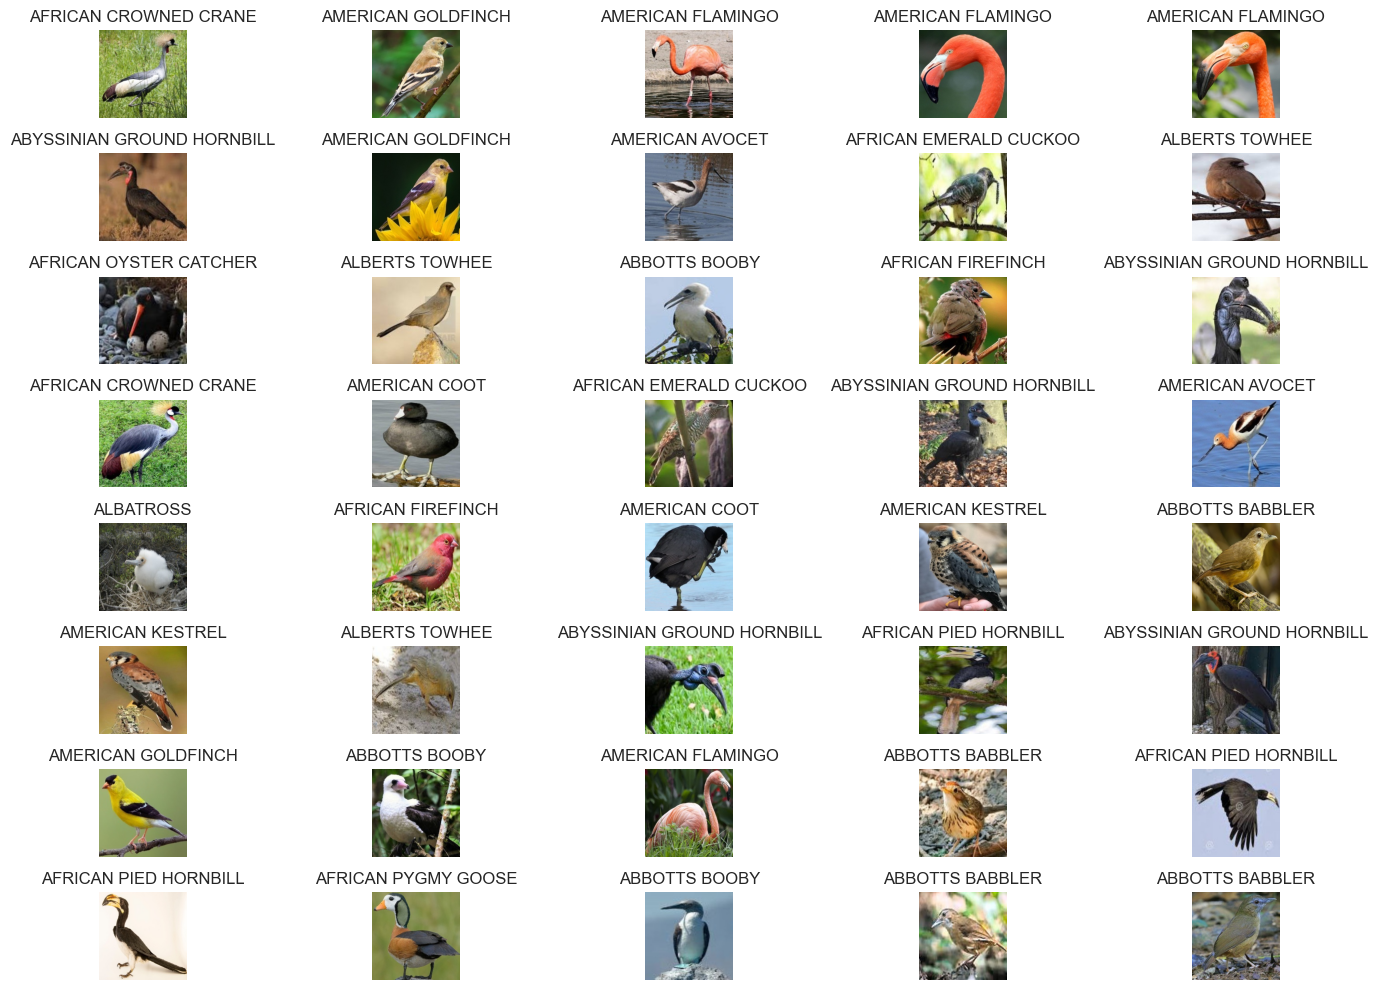

In [ ]:
# TODO: Plot some of images
import matplotlib.image as mpimg

num_images = 40
num_rows = 8
num_cols = 5

# Plot the images
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

for i in range(num_images):
    row = combined_df.iloc[i]
    image_path = os.path.join('archive/train', row['filename'])
    image = mpimg.imread(image_path)

    # Calculate subplot position
    row_idx = i // num_cols  # Row index
    col_idx = i % num_cols  # Column index

    if num_rows > 1:
        axes[row_idx, col_idx].imshow(image)
        axes[row_idx, col_idx].set_title(row['outcome'])
        axes[row_idx, col_idx].axis('off')
    else:
        axes[col_idx].imshow(image)
        axes[col_idx].set_title(row['outcome'])
        axes[col_idx].axis('off')

plt.tight_layout()
plt.show()


## Dataset Distribution
plot the distribution of the dataset, both training and validation set

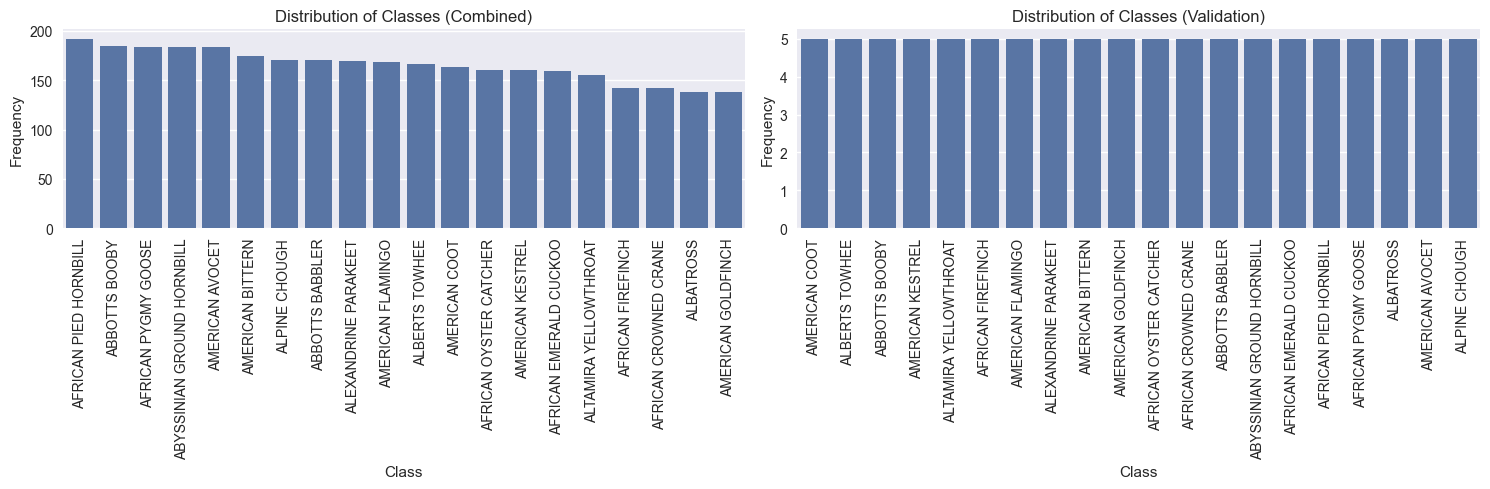

In [ ]:
# TODO: Plot the distribution of classes

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot for combined data
class_counts_combined = combined_df['outcome'].value_counts()
sea.barplot(x=class_counts_combined.index, y=class_counts_combined.values, ax=axes[0])
axes[0].set_title('Distribution of Classes (Combined)')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Frequency')
axes[0].tick_params(axis='x', rotation=90)

# Plot for validation data
class_counts_valid = valid_df['outcome'].value_counts()
sea.barplot(x=class_counts_valid.index, y=class_counts_valid.values, ax=axes[1])
axes[1].set_title('Distribution of Classes (Validation)')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Frequency')
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

## Dataset Preparation
Now we are going to build the dataset by using `Dataset` and `DataLoader` classes within PyTorch. I recommend you to randomly crop the images to (160, 160) and then normalize them.

In [9]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import os
from torchvision import transforms


class ToGrayAndColorTensor:
    def __init__(self):
        # Normalization stats for grayscale and color images
        self.gray_normalize = transforms.Normalize(mean=[0.5], std=[0.5])
        self.color_normalize = transforms.Normalize(mean=[0.485], std=[0.229])

    def __call__(self, img):
        # img is PIL Image (RGB)
        # Convert to grayscale tensor
        gray = transforms.functional.rgb_to_grayscale(
            img, num_output_channels=1)
        gray_tensor = transforms.ToTensor()(gray)
        gray_tensor = self.gray_normalize(gray_tensor)

        # Convert original to tensor and normalize color
        color_tensor = transforms.ToTensor()(img)
        color_tensor = self.color_normalize(color_tensor)
        return gray_tensor, color_tensor


class BirdDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        """
        df: pandas DataFrame containing image filenames or paths
        img_dir: directory containing the images
        transform: torchvision transforms for data augmentation and preprocessing
        """
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.iloc[idx]['filename']
        img_path = os.path.join(self.img_dir, img_name)
        img = Image.open(img_path).convert('RGB')

        if self.transform:
            # Apply all transforms (including both grayscale and color conversion)
            gray_img, color_img = self.transform(img)
        else:
            # Default case without transform
            color_img = transforms.ToTensor()(img)
            gray_img = transforms.ToTensor()(img.convert('L'))

        return gray_img, color_img


# Define custom transformations including RandomCrop and ColorJitter
transform = transforms.Compose([
    transforms.RandomCrop((160, 160)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1,
                           saturation=0.2, hue=0.02),
    ToGrayAndColorTensor()
])

# Instantiate datasets with the updated transformations
train_dataset = BirdDataset(
    df=train_df, img_dir="/content/drive/MyDrive/archive/train", transform=transform)
valid_dataset = BirdDataset(
    df=valid_df, img_dir="/content/drive/MyDrive/archive/valid", transform=transform)
test_dataset = BirdDataset(
    df=test_df, img_dir="/content/drive/MyDrive/archive/test", transform=None)

# Create DataLoaders for batching
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

**Why is data augmentation pivotal in training models for image tasks, and what techniques are beneficial for this particular assignment?**

## Model Architecture
The model has an encoder block for encoding the grayscale image into a lower representation followed by a decoder block to generate the colorized image.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torchvision import models


class PerceptualLoss(nn.Module):
    def __init__(self, feature_layers=[0, 5, 10, 19, 28], use_half=False):
        super(PerceptualLoss, self).__init__()
        self.vgg = models.vgg16(pretrained=True).features
        self.feature_layers = feature_layers
        self.use_half = use_half

        # Freeze the VGG model weights
        for param in self.vgg.parameters():
            param.requires_grad = False

    def forward(self, x, y):
        loss = 0
        x = self.vgg(x)
        y = self.vgg(y)

        for i in self.feature_layers:
            loss += torch.nn.functional.mse_loss(x[i], y[i])

        return loss

# Encoder definition
class Encoder(nn.Module):
    def __init__(self, do_bn=False):
        super(Encoder, self).__init__()
        self.do_bn = do_bn
        self.encoder = nn.Sequential(
            self.inner_block(1, 64, maxpool=2),
            self.inner_block(64, 128, maxpool=2),
            self.inner_block(128, 256, maxpool=2),
            self.inner_block(256, 512, maxpool=2)
        )

    def inner_block(self, in_c, out_c, maxpool=2):
        layers = [nn.Conv2d(in_c, out_c, kernel_size=3, stride=1, padding=1)]
        if self.do_bn:
            layers.append(nn.BatchNorm2d(out_c))
        layers.append(nn.ReLU(inplace=True))
        layers.append(nn.MaxPool2d(kernel_size=maxpool, stride=maxpool))
        return nn.Sequential(*layers)

    def forward(self, x):
        return self.encoder(x)


# Decoder definition
class Decoder(nn.Module):
    def __init__(self, do_bn=False):
        super(Decoder, self).__init__()
        self.do_bn = do_bn
        self.decoder = nn.Sequential(
            self.inner_block(512, 256, out=True),
            self.inner_block(256, 128, out=True),
            self.inner_block(128, 64, out=True),
            self.inner_block(64, 3, out=True, final=True)
        )

    def inner_block(self, in_c, out_c, out=False, final=False):
        layers = [nn.ConvTranspose2d(
            in_c, out_c, kernel_size=3, stride=2, padding=1, output_padding=1)]
        if self.do_bn and not final:
            layers.append(nn.BatchNorm2d(out_c))
        layers.append(nn.ReLU(inplace=True) if not final else nn.Tanh())
        return nn.Sequential(*layers)

    def forward(self, h):
        return self.decoder(h)


# Complete network combining the encoder and decoder
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.encoder = Encoder(do_bn=True)
        self.decoder = Decoder(do_bn=True)

    def forward(self, x):
        latent = self.encoder(x)
        return self.decoder(latent)

    def compute_loss(self, pred, target):
        # Compute MSE loss between the reconstructed RGB image and the actual RGB image
        loss = nn.MSELoss()(pred, target)
        return loss

    def training_step(self, X, y):
        # Forward pass and compute loss
        outputs = self(X)
        loss = self.compute_loss(outputs, y)
        return loss

    def validation_step(self, X, y):
        # Forward pass and compute loss
        outputs = self(X)
        loss = self.compute_loss(outputs, y)
        return loss

    def train_model(self, train_loader, val_loader, optimizer, n_epochs=10, device='cpu'):
        # Lists to store loss values for plotting
        train_losses = []
        val_losses = []

        for epoch in range(n_epochs):
            # Training phase
            self.train()  # Sets the model to training mode
            train_loss = 0.0
            for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{n_epochs} - Training"):
                inputs, targets = batch  # inputs are grayscale, targets are RGB
                inputs, targets = inputs.to(device), targets.to(device)
                optimizer.zero_grad()
                loss = self.training_step(inputs, targets)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
            train_loss /= len(train_loader)
            train_losses.append(train_loss)  # Store training loss

            # Validation phase
            self.eval()  # Sets the model to evaluation mode
            val_loss = 0.0
            with torch.no_grad():
                for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{n_epochs} - Validation"):
                    inputs, targets = batch  # inputs are grayscale, targets are RGB
                    inputs, targets = inputs.to(device), targets.to(device)
                    loss = self.validation_step(inputs, targets)
                    val_loss += loss.item()
            val_loss /= len(val_loader)
            val_losses.append(val_loss)  # Store validation loss

            # Log metrics
            print(
                f"Epoch {epoch+1}/{n_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        return train_losses, val_losses

In [ ]:
# TODO: print the model
model = Net().to(device)

print(model)

Net(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (1): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (2): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Training Phase

In [ ]:
# TODO: Train
# Students should implement the training loop. During training, monitor both training and validation metrics
# to ensure the model learns effectively without overfitting.
import torch.optim as optim


optimizer = optim.Adam(model.parameters(), lr=0.001)

# Assuming train_dataloader and val_dataloader are defined
train_losses, val_losses = model.train_model(train_loader=train_loader, val_loader=valid_loader,
                  optimizer=optimizer, n_epochs=50, device=device)

Epoch 1/50 - Validation: 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]


Epoch 1/50 - Train Loss: 0.4947, Val Loss: 0.4765


Epoch 2/50 - Validation: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]


Epoch 2/50 - Train Loss: 0.3917, Val Loss: 0.4127


Epoch 3/50 - Validation: 100%|██████████| 4/4 [00:01<00:00,  3.18it/s]


Epoch 3/50 - Train Loss: 0.3698, Val Loss: 0.3891


Epoch 4/50 - Validation: 100%|██████████| 4/4 [00:01<00:00,  3.20it/s]


Epoch 4/50 - Train Loss: 0.3525, Val Loss: 0.3850


Epoch 5/50 - Validation: 100%|██████████| 4/4 [00:01<00:00,  3.27it/s]


Epoch 5/50 - Train Loss: 0.3457, Val Loss: 0.3777


Epoch 6/50 - Validation: 100%|██████████| 4/4 [00:01<00:00,  3.17it/s]


Epoch 6/50 - Train Loss: 0.3425, Val Loss: 0.3679


Epoch 7/50 - Validation: 100%|██████████| 4/4 [00:01<00:00,  3.08it/s]


Epoch 7/50 - Train Loss: 0.3367, Val Loss: 0.3856


Epoch 8/50 - Validation: 100%|██████████| 4/4 [00:01<00:00,  3.10it/s]


Epoch 8/50 - Train Loss: 0.3343, Val Loss: 0.3811


Epoch 9/50 - Validation: 100%|██████████| 4/4 [00:01<00:00,  3.29it/s]


Epoch 9/50 - Train Loss: 0.3369, Val Loss: 0.3462


Epoch 10/50 - Validation: 100%|██████████| 4/4 [00:01<00:00,  3.33it/s]


Epoch 10/50 - Train Loss: 0.3276, Val Loss: 0.3603


Epoch 11/50 - Validation: 100%|██████████| 4/4 [00:01<00:00,  2.59it/s]


Epoch 11/50 - Train Loss: 0.3290, Val Loss: 0.4192


Epoch 12/50 - Validation: 100%|██████████| 4/4 [00:01<00:00,  3.35it/s]


Epoch 12/50 - Train Loss: 0.3291, Val Loss: 0.3546


Epoch 13/50 - Validation: 100%|██████████| 4/4 [00:01<00:00,  3.29it/s]


Epoch 13/50 - Train Loss: 0.3223, Val Loss: 0.3835


Epoch 14/50 - Validation: 100%|██████████| 4/4 [00:01<00:00,  3.17it/s]


Epoch 14/50 - Train Loss: 0.3202, Val Loss: 0.3577


Epoch 15/50 - Validation: 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]


Epoch 15/50 - Train Loss: 0.3212, Val Loss: 0.3861


Epoch 16/50 - Validation: 100%|██████████| 4/4 [00:01<00:00,  2.76it/s]


Epoch 16/50 - Train Loss: 0.3177, Val Loss: 0.3282


Epoch 17/50 - Validation: 100%|██████████| 4/4 [00:01<00:00,  2.70it/s]


Epoch 17/50 - Train Loss: 0.3177, Val Loss: 0.3658


Epoch 18/50 - Validation: 100%|██████████| 4/4 [00:01<00:00,  3.20it/s]


Epoch 18/50 - Train Loss: 0.3177, Val Loss: 0.3361


Epoch 19/50 - Validation: 100%|██████████| 4/4 [00:01<00:00,  3.38it/s]


Epoch 19/50 - Train Loss: 0.3185, Val Loss: 0.3773


Epoch 20/50 - Validation: 100%|██████████| 4/4 [00:01<00:00,  2.67it/s]


Epoch 20/50 - Train Loss: 0.3160, Val Loss: 0.3373


Epoch 21/50 - Validation: 100%|██████████| 4/4 [00:01<00:00,  3.04it/s]


Epoch 21/50 - Train Loss: 0.3187, Val Loss: 0.3494


Epoch 22/50 - Validation: 100%|██████████| 4/4 [00:01<00:00,  2.78it/s]


Epoch 22/50 - Train Loss: 0.3174, Val Loss: 0.3261


Epoch 23/50 - Validation: 100%|██████████| 4/4 [00:01<00:00,  2.73it/s]


Epoch 23/50 - Train Loss: 0.3131, Val Loss: 0.3559


Epoch 24/50 - Validation: 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]


Epoch 24/50 - Train Loss: 0.3111, Val Loss: 0.3388


Epoch 25/50 - Validation: 100%|██████████| 4/4 [00:01<00:00,  2.99it/s]


Epoch 25/50 - Train Loss: 0.3104, Val Loss: 0.3250


Epoch 26/50 - Validation: 100%|██████████| 4/4 [00:01<00:00,  2.60it/s]


Epoch 26/50 - Train Loss: 0.3101, Val Loss: 0.3556


Epoch 27/50 - Validation: 100%|██████████| 4/4 [00:01<00:00,  3.36it/s]


Epoch 27/50 - Train Loss: 0.3055, Val Loss: 0.3624


Epoch 28/50 - Validation: 100%|██████████| 4/4 [00:01<00:00,  2.44it/s]


Epoch 28/50 - Train Loss: 0.3095, Val Loss: 0.3223


Epoch 29/50 - Validation: 100%|██████████| 4/4 [00:01<00:00,  3.08it/s]


Epoch 29/50 - Train Loss: 0.3078, Val Loss: 0.3291


Epoch 30/50 - Validation: 100%|██████████| 4/4 [00:01<00:00,  2.48it/s]


Epoch 30/50 - Train Loss: 0.3103, Val Loss: 0.3533


Epoch 31/50 - Validation: 100%|██████████| 4/4 [00:01<00:00,  2.50it/s]


Epoch 31/50 - Train Loss: 0.3100, Val Loss: 0.3442


Epoch 32/50 - Validation: 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]


Epoch 32/50 - Train Loss: 0.3087, Val Loss: 0.3334


Epoch 33/50 - Validation: 100%|██████████| 4/4 [00:01<00:00,  3.07it/s]


Epoch 33/50 - Train Loss: 0.3071, Val Loss: 0.3129


Epoch 34/50 - Validation: 100%|██████████| 4/4 [00:01<00:00,  2.98it/s]


Epoch 34/50 - Train Loss: 0.3043, Val Loss: 0.3275


Epoch 35/50 - Validation: 100%|██████████| 4/4 [00:01<00:00,  2.76it/s]


Epoch 35/50 - Train Loss: 0.3065, Val Loss: 0.3125


Epoch 36/50 - Validation: 100%|██████████| 4/4 [00:01<00:00,  2.25it/s]


Epoch 36/50 - Train Loss: 0.3051, Val Loss: 0.3247


Epoch 37/50 - Validation: 100%|██████████| 4/4 [00:01<00:00,  3.26it/s]


Epoch 37/50 - Train Loss: 0.3033, Val Loss: 0.3683


Epoch 38/50 - Validation: 100%|██████████| 4/4 [00:01<00:00,  2.59it/s]


Epoch 38/50 - Train Loss: 0.3029, Val Loss: 0.3398


Epoch 39/50 - Validation: 100%|██████████| 4/4 [00:01<00:00,  2.10it/s]


Epoch 39/50 - Train Loss: 0.3022, Val Loss: 0.3262


Epoch 40/50 - Validation: 100%|██████████| 4/4 [00:01<00:00,  2.26it/s]


Epoch 40/50 - Train Loss: 0.3013, Val Loss: 0.3129


Epoch 41/50 - Validation: 100%|██████████| 4/4 [00:01<00:00,  2.30it/s]


Epoch 41/50 - Train Loss: 0.2995, Val Loss: 0.3220


Epoch 42/50 - Validation: 100%|██████████| 4/4 [00:01<00:00,  2.57it/s]


Epoch 42/50 - Train Loss: 0.3020, Val Loss: 0.3206


Epoch 43/50 - Validation: 100%|██████████| 4/4 [00:01<00:00,  2.23it/s]


Epoch 43/50 - Train Loss: 0.2995, Val Loss: 0.3639


Epoch 44/50 - Validation: 100%|██████████| 4/4 [00:02<00:00,  1.98it/s]


Epoch 44/50 - Train Loss: 0.3050, Val Loss: 0.3509


Epoch 45/50 - Validation: 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]


Epoch 45/50 - Train Loss: 0.2999, Val Loss: 0.3382


Epoch 46/50 - Validation: 100%|██████████| 4/4 [00:01<00:00,  3.01it/s]


Epoch 46/50 - Train Loss: 0.2992, Val Loss: 0.3108


Epoch 47/50 - Validation: 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]


Epoch 47/50 - Train Loss: 0.2993, Val Loss: 0.3138


Epoch 48/50 - Validation: 100%|██████████| 4/4 [00:01<00:00,  2.33it/s]


Epoch 48/50 - Train Loss: 0.2995, Val Loss: 0.3207


Epoch 49/50 - Validation: 100%|██████████| 4/4 [00:01<00:00,  2.66it/s]


Epoch 49/50 - Train Loss: 0.2979, Val Loss: 0.3486


Epoch 50/50 - Validation: 100%|██████████| 4/4 [00:01<00:00,  2.83it/s]

Epoch 50/50 - Train Loss: 0.3016, Val Loss: 0.3431


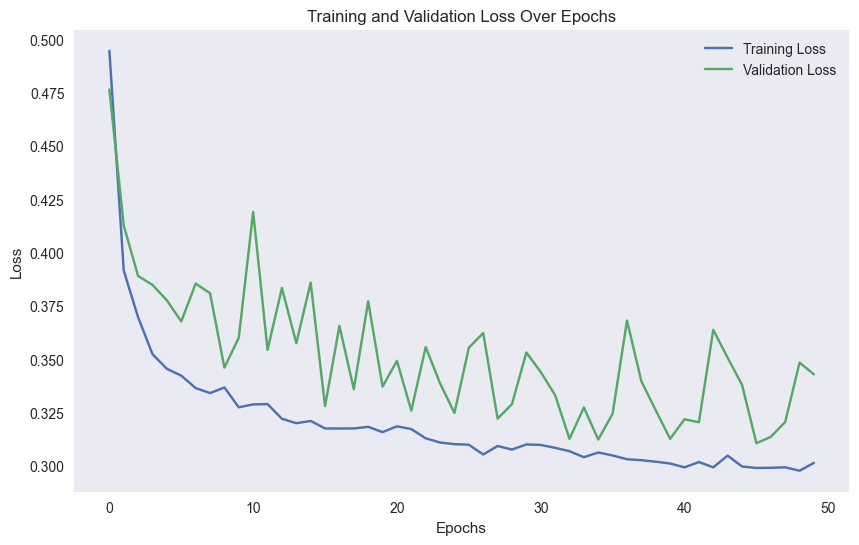

In [ ]:
# TODO: Plot training and validation loss over epochs

def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label="Training Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Over Epochs")
    plt.legend()
    plt.grid()
    plt.show()

plot_losses(train_losses, val_losses)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7353693..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7061119..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.66478354..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.66678315..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.85877496..1.0].


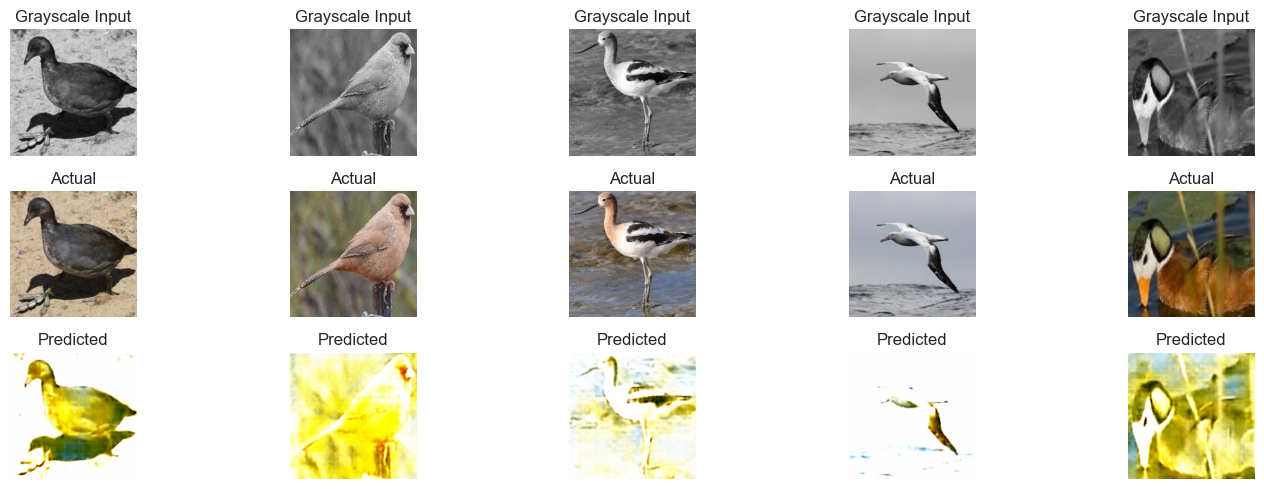

In [ ]:
def plot_predictions(model, dataloader, device='cpu'):
    """Plots grayscale inputs, actual targets, and predicted outputs."""
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            # Convert tensors to numpy arrays for visualization
            inputs = inputs.cpu().numpy()
            targets = targets.cpu().numpy()
            outputs = outputs.cpu().numpy()

            num_examples = min(len(inputs), 5)
            plt.figure(figsize=(15, 5))
            for i in range(num_examples):
                # Grayscale Input
                plt.subplot(3, num_examples, i + 1)
                if inputs.shape[1] == 1:  # Grayscale input
                    plt.imshow(inputs[i, 0], cmap='gray')
                else:  # RGB input
                    plt.imshow(inputs[i].transpose(1, 2, 0))
                plt.title("Grayscale Input")
                plt.axis('off')

                # Actual Target
                plt.subplot(3, num_examples, i + 1 + num_examples)
                if targets.shape[1] == 1:  # Grayscale target
                    plt.imshow(targets[i, 0], cmap='gray')
                else:  # RGB target
                    plt.imshow(targets[i].transpose(1, 2, 0))
                plt.title("Actual")
                plt.axis('off')

                # Predicted Output
                plt.subplot(3, num_examples, i + 1 + 2 * num_examples)
                if outputs.shape[1] == 1:  # Grayscale output
                    plt.imshow(outputs[i, 0], cmap='gray')
                else:  # RGB output
                    plt.imshow(outputs[i].transpose(1, 2, 0))
                plt.title("Predicted")
                plt.axis('off')

            plt.tight_layout()
            plt.show()
            break

plot_predictions(model, test_loader, device=device)

In [18]:

class PerceptualLoss(nn.Module):
    def __init__(self, feature_layers=None, use_half=False):
        super(PerceptualLoss, self).__init__()
        if feature_layers is None:
            feature_layers = [3, 8, 15, 22]
        vgg = models.vgg16(weights=models.VGG16_Weights.DEFAULT).features
        
        self.slices = nn.ModuleList()
        previous_layer = 0
        
        for layer in feature_layers:
            slice_ = vgg[previous_layer:layer]
            self.slices.append(slice_)
            previous_layer = layer
            
        for parameter in self.parameters():
            parameter.requires_grad = False
            
        if use_half:
            self.half()
            
        self.to(device)

    def forward(self, x, y):
        loss = 0.0
        with torch.no_grad():
            pass
        
        for idx in self.slices:
            x = idx(x)
            y = idx(y)
            loss += torch.nn.functional.l1_loss(x, y)
            
        
        return loss

class Encoder(nn.Module):
    def __init__(self, do_bn=False):
        super(Encoder, self).__init__()
        self.do_bn = do_bn
        
        self.block1 = self.inner_block(1, 64) # Grayscale input
        self.block2 = self.inner_block(64, 128)
        self.block3 = self.inner_block(128, 256)
        self.block4 = self.inner_block(256, 512)

    def inner_block(self, in_c, out_c):
        
        layers = [
            nn.Conv2d(in_c, out_c, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.1) # We can change it up to 0.5
        ]
        
        if self.do_bn:
            layers.insert(1, nn.BatchNorm2d(out_c))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        return x

class Decoder(nn.Module):
    def __init__(self, do_bn=False):
        super(Decoder, self).__init__()
        self.do_bn = do_bn
        
        self.block1 = self.inner_block(512, 256)
        self.block2 = self.inner_block(256, 128)
        self.block3 = self.inner_block(128, 64)
        self.block4 = self.inner_block(64, 3, out=True) # RGB output

    def inner_block(self, in_c, out_c, out=False):
        layers = [nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2)]
        if not out:
            if self.do_bn:
                layers.append(nn.BatchNorm2d(out_c))
                
                
            layers.append(nn.ReLU(True))
            layers.append(nn.Dropout(0.1)) # We can change it up to 0.5
            
        else:
            layers.append(nn.Tanh())
            
            
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        return x

class Net(nn.Module):
    def __init__(self, lr=1e-3, do_bn=False, use_half=False, feature_layers=None):
        super(Net, self).__init__()
        
        self.encoder = Encoder(do_bn=do_bn).to(device)
        self.decoder = Decoder(do_bn=do_bn).to(device)
        
        self.perceptual_loss = PerceptualLoss(feature_layers=feature_layers, use_half=use_half)

        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.l1_loss = nn.L1Loss()
        self.mse_loss = nn.MSELoss()

        self.vgg_normalized = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                             std=[0.229, 0.224, 0.225])

    def forward(self, x):
        h = self.encoder(x)
        out = self.decoder(h)
        return out

    def compute_loss(self, pred, target):
        
        target_val = (target + 1)/2
        prediction = (pred + 1)/2
        
        new_prediction = torch.stack([self.vgg_normalized(p) for p in prediction])
        new_target = torch.stack([self.vgg_normalized(t) for t in target_val])

        computed_perceptual_loss = self.perceptual_loss(new_prediction, new_target)
        computed_l1_loss = self.l1_loss(pred, target)
        computed_mse_loss = self.mse_loss(pred, target)
        
        return computed_perceptual_loss + computed_l1_loss + computed_mse_loss

    def training_step(self, batch):
        
        gray_input, RGB_input = batch
        gray_input, RGB_input = gray_input.to(device), RGB_input.to(device)

        self.optimizer.zero_grad()
        output = self.forward(gray_input)
        loss = self.compute_loss(output, RGB_input)
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def validation_step(self, batch):
        
        gray_input, RGB_input = batch
        gray_input, RGB_input = gray_input.to(device), RGB_input.to(device)
        
        with torch.no_grad():
            output = self.forward(gray_input)
            loss = self.compute_loss(output, RGB_input)
        return loss.item()

    def train_model(self, train_loader, val_loader=None, epochs=10):
        
        for epoch in range(epochs):
            self.train()
            train_losses = []
            for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{epochs}"):
                loss = self.training_step(batch)
                train_losses.append(loss)

            if val_loader is not None:
                self.eval()
                val_losses = []
                for batch in val_loader:
                    val_loss = self.validation_step(batch)
                    val_losses.append(val_loss)
                print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {sum(train_losses)/len(train_losses):.4f}, Val Loss: {sum(val_losses)/len(val_losses):.4f}")
            else:
                print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {sum(train_losses)/len(train_losses):.4f}")
                
        return train_losses,val_losses

In [19]:
perc_model = Net()
print(perc_model)

Net(
  (encoder): Encoder(
    (block1): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.1, inplace=False)
    )
    (block2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.1, inplace=False)
    )
    (block3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.1, inplace=False)
    )
    (block4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=2, st

In [25]:
def plot_predictions(model, dataloader, device='cpu'):
    """Plots grayscale inputs, actual targets, and predicted outputs."""
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            # Convert tensors to numpy arrays for visualization
            inputs = inputs.cpu().numpy()
            targets = targets.cpu().numpy()
            outputs = outputs.cpu().numpy()

            num_examples = min(len(inputs), 5)
            plt.figure(figsize=(15, 5))
            for i in range(num_examples):
                # Grayscale Input
                plt.subplot(3, num_examples, i + 1)
                if inputs.shape[1] == 1:  # Grayscale input
                    plt.imshow(inputs[i, 0], cmap='gray')
                else:  # RGB input
                    plt.imshow(inputs[i].transpose(1, 2, 0))
                plt.title("Grayscale Input")
                plt.axis('off')

                # Actual Target
                plt.subplot(3, num_examples, i + 1 + num_examples)
                if targets.shape[1] == 1:  # Grayscale target
                    plt.imshow(targets[i, 0], cmap='gray')
                else:  # RGB target
                    plt.imshow(targets[i].transpose(1, 2, 0))
                plt.title("Actual")
                plt.axis('off')

                # Predicted Output
                plt.subplot(3, num_examples, i + 1 + 2 * num_examples)
                if outputs.shape[1] == 1:  # Grayscale output
                    plt.imshow(outputs[i, 0], cmap='gray')
                else:  # RGB output
                    plt.imshow(outputs[i].transpose(1, 2, 0))
                plt.title("Predicted")
                plt.axis('off')

            plt.tight_layout()
            plt.show()
            break

In [ ]:
prec_train_loss,prec_val_loss = perc_model.train_model(train_loader, valid_loader, epochs=10)

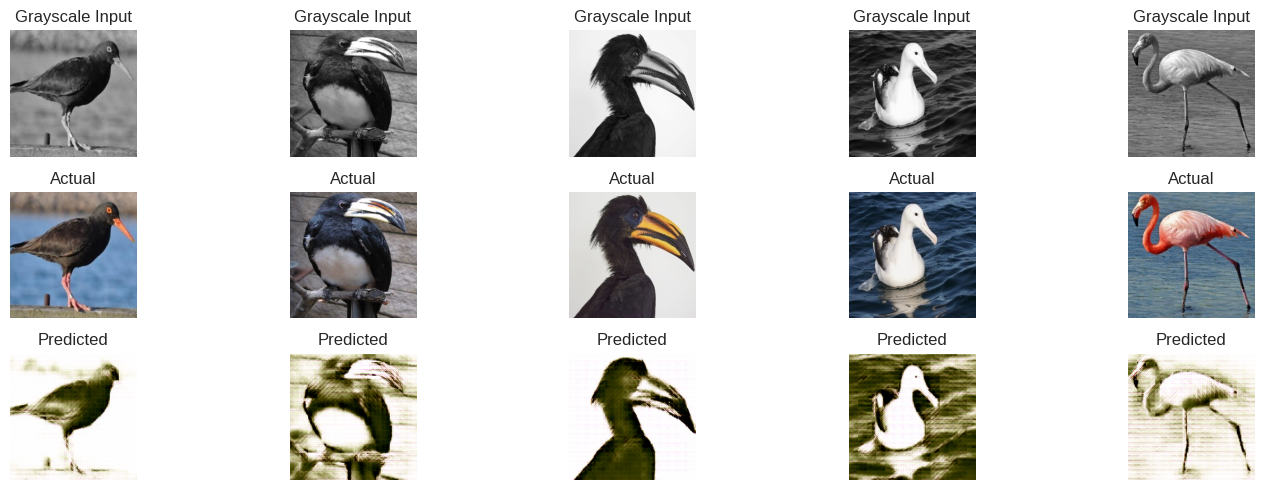

In [27]:
# Plot the second model outcomes with 10 epoches
plot_predictions(perc_model, test_loader, device=device)

It seems that using perceptual loss is better than noraml loss for predicting the actual color even though the second model was trained with only 10 epochs in compare to 50 epochs for the first model.<br/>
If we use more epochs we can get even more accurate model.<br/>


In [ ]:
# Visualizing the Latent Space
# Latent space visualizations are a powerful tool to understand how the VAE encodes data.
# In this task, students are required to implement a visualization routine to observe the distribution of their data within the latent space.
# The goal is to project high-dimensional encoded data into two dimensions using t-SNE and inspect how different data points are clustered.
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch

# Function to visualize the latent space


def visualize_latent_space(encoder, data_loader, num_samples=1000):
    """
    Uses a 2-dimensional t-SNE plot to visualize latent space of encoded images.

    Parameters:
    encoder (torch.nn.Module): The encoder model component.
    data_loader (torch.utils.data.DataLoader)
    num_samples (int): Number of samples to visualize
    """
    encoder.eval()
    latent_vectors = []
    outcomes = []
    with torch.no_grad():
        for batch_idx, (grayscale_image, original_image) in enumerate(data_loader):
            if len(latent_vectors) >= num_samples:
                break

            grayscale_image = grayscale_image.to(
                next(encoder.parameters()).device)
            encoded = encoder(grayscale_image)

            # Flatten the latent space representation
            latent_vectors.extend(encoded.view(
                encoded.size(0), -1).cpu().numpy())
            # Ensure outcomes are NumPy arrays
            outcomes.extend(original_image.cpu().numpy())

    # Convert latent_vectors to NumPy array
    import numpy as np
    latent_vectors = np.array(latent_vectors)

    # t-SNE reduction to 2D for visualization
    tsne = TSNE(n_components=2, random_state=42)
    latent_vectors_2d = tsne.fit_transform(latent_vectors)

    # Plotting the 2D projection
    plt.figure(figsize=(8, 6))
    plt.scatter(
        latent_vectors_2d[:, 0], latent_vectors_2d[:, 1], c=outcomes, cmap='viridis')
    plt.colorbar(label='Outcome')
    plt.title('Latent Space Visualization with t-SNE')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.show()





# TODO: Use visualize_latent_space function post-training to observe the latent space

visualize_latent_space(model.encoder, test_loader)

How the distribution of points in the latent space reflects the VAE's capability to generalize grayscale images into colored outputs.

1. **Clustering and Class Representation**:
    - Can you identify clusters in the latent space that correspond to specific image features or categories?<br/>
    
            Yes, clusters in the latent space can correspond to specific image features or categories. These clusters emerge when the VAE learns to group images with similar characteristics, such as texture, shape, or other visual attributes that influence color.
        
    - How do these clusters inform us about the VAE's ability to differentiate between various input characteristics related to color information?<br/>

            The presence of distinct clusters in the latent space indicates that the VAE is successfully differentiating between various input characteristics, such as texture, shape, and lighting, that are related to color. Each cluster likely corresponds to a particular set of features, allowing the VAE to learn associations between grayscale patterns and their appropriate color representations. Well-separated clusters suggest that the model is effectively capturing and isolating different colorization contexts (e.g., nature scenes vs. urban environments). Overlapping or poorly defined clusters, however, may indicate that the VAE struggles to differentiate certain characteristics, which could affect its ability to generate accurate or diverse color outputs for similar grayscale inputs.



2. **Continuity and Transitions**:
    - Analyze whether neighboring points in the latent space result in similar or different color outputs. What does this continuity suggest about the latent representation's smoothness?<br/>

            When neighboring points in the latent space result in similar color outputs, it suggests that the latent space is smooth and well-structured. This continuity is important for ensuring that subtle variations in input images (e.g., slight changes in lighting, shading, or texture) lead to corresponding smooth transitions in colorization. A smooth latent space implies that the VAE has learned a continuous mapping between grayscale images and their color counterparts, allowing for more realistic and consistent color outputs. On the other hand, if neighboring points produce drastically different outputs, this discontinuity suggests a poorly structured latent space, which could lead to unrealistic or inconsistent colorization, especially for inputs with gradual variations.

    - How could these visual transitions impact the quality and realism of the generated colorations, especially for input images that exhibit gradual changes (e.g., transitions in lighting or shading)?<br/>

            Visual transitions in the latent space directly impact the quality and realism of generated colorations, particularly for images with gradual changes, such as variations in lighting or shading. If the latent space is smooth and continuous, neighboring points will produce colorizations that reflect these gradual transitions, ensuring that the output is realistic and coherent. For instance, subtle shifts in lighting or shading would result in similarly gradual color changes in the output. However, if there are discontinuities in the latent space, the VAE may generate abrupt or unrealistic color transitions, disrupting the natural flow of color in the image. This could lead to unnatural color boundaries or inconsistencies, reducing the quality of colorization for images with smooth, gradual changes.

3. **Effectiveness of Dimensionality Reduction**:
    - Assess the effectiveness of t-SNE in projecting high-dimensional latent vectors into a comprehensible 2D representation. What limitations might exist, and how do they affect your interpretation?<br/>

            t-SNE is effective for visualizing high-dimensional latent vectors in a 2D space, allowing us to identify clusters and local patterns in the latent space. Its strength lies in preserving local similarities and revealing groupings of similar data points. However, t-SNE has limitations: it may distort global structure by focusing more on local distances, leading to a potential misrepresentation of the overall arrangement of data points. For example, points that are distant in high-dimensional space could appear close in the 2D projection, or vice versa. This distortion can affect the interpretation of how well the latent space separates different features or categories. To mitigate these limitations, it’s useful to complement t-SNE with other techniques (like PCA or UMAP) that offer more balanced views of both local and global structures.


Elaborate on how the encoder-decoder architecture facilitates the learning of complex data distributions in image colorization. How does this architecture differ from a simple autoencoder?<br/>

    The encoder-decoder architecture is crucial in learning complex data distributions for tasks like image colorization because it not only learns to compress and represent images but also generates new information (colors) in the output. This differs from a simple autoencoder, which primarily focuses on reconstructing the original input without generating novel features. The architecture's ability to learn complex latent representations makes it particularly effective in tasks like colorization, where understanding both the structure and color relationships is essential.

Analyze the role of perceptual loss in enhancing the quality of colorized images. How does perceptual loss measure image similarity compared to pixel-wise losses like Mean Squared Error (MSE)?<br/>

    Perceptual loss enhances the quality of colorized images by encouraging the model to focus on perceptually important features, rather than just pixel-wise accuracy. Compared to MSE, perceptual loss leads to more realistic and natural-looking colorizations by preserving high-level image structures, ensuring that the generated colors and textures align better with human visual perception. This makes perceptual loss particularly useful for complex tasks like image colorization, where context, texture, and subtle color transitions are essential.

Discuss how the latent space in a VAE impacts the fidelity and diversity of generated color images. What effects could varying the dimensionality of the latent space have?<br/>

    The dimensionality of the latent space in a VAE has a direct impact on both the fidelity and diversity of generated color images. Increasing the dimensionality allows the model to capture more detailed and nuanced color information, resulting in better colorization quality and more diverse outputs. However, this comes with the risk of overfitting and longer training times. On the other hand, a lower-dimensional latent space may lead to faster training but with a loss in image quality and diversity.

    Ultimately, the choice of latent space dimensionality should balance between model capacity, data complexity, and desired output diversity, depending on the specific requirements of the colorization task.

    

# Image Segmentation with U-Net
Image segmentation is a crucial task in computer vision aimed at dividing an image into meaningful segments or objects. The U-Net architecture, famed for its utility in medical imaging, excels at this by leveraging its encoder-decoder structure, which efficiently learns and reconstructs image details. In this task, the U-Net is trained on pairs of images and masks, enabling it to delineate object boundaries at the pixel level with high precision. The training process involves preprocessing the data, adjusting network parameters, and evaluating the model using metrics like Intersection over Union (IoU) to ensure effective segmentation. Successful implementation of U-Net for this purpose can revolutionize applications in areas like autonomous vehicles, medical diagnosis, and agricultural monitoring.

Dataset: https://drive.google.com/drive/folders/1g97fGNQ6buixT8Hp96QyEYOMNKby5Oe8?usp=sharing

## Importing necessary libraries

In [ ]:
# import system libs
from sklearn.model_selection import train_test_split
from torchvision.transforms import ToTensor
import os
import time
import glob
import shutil

# import data handling tools
import cv2
import PIL
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
import random
from PIL import Image
from torch.utils.data import Dataset, DataLoader




# import necessary PyTorch libraries
...
print ('modules loaded')

modules loaded


## Load the Dataset

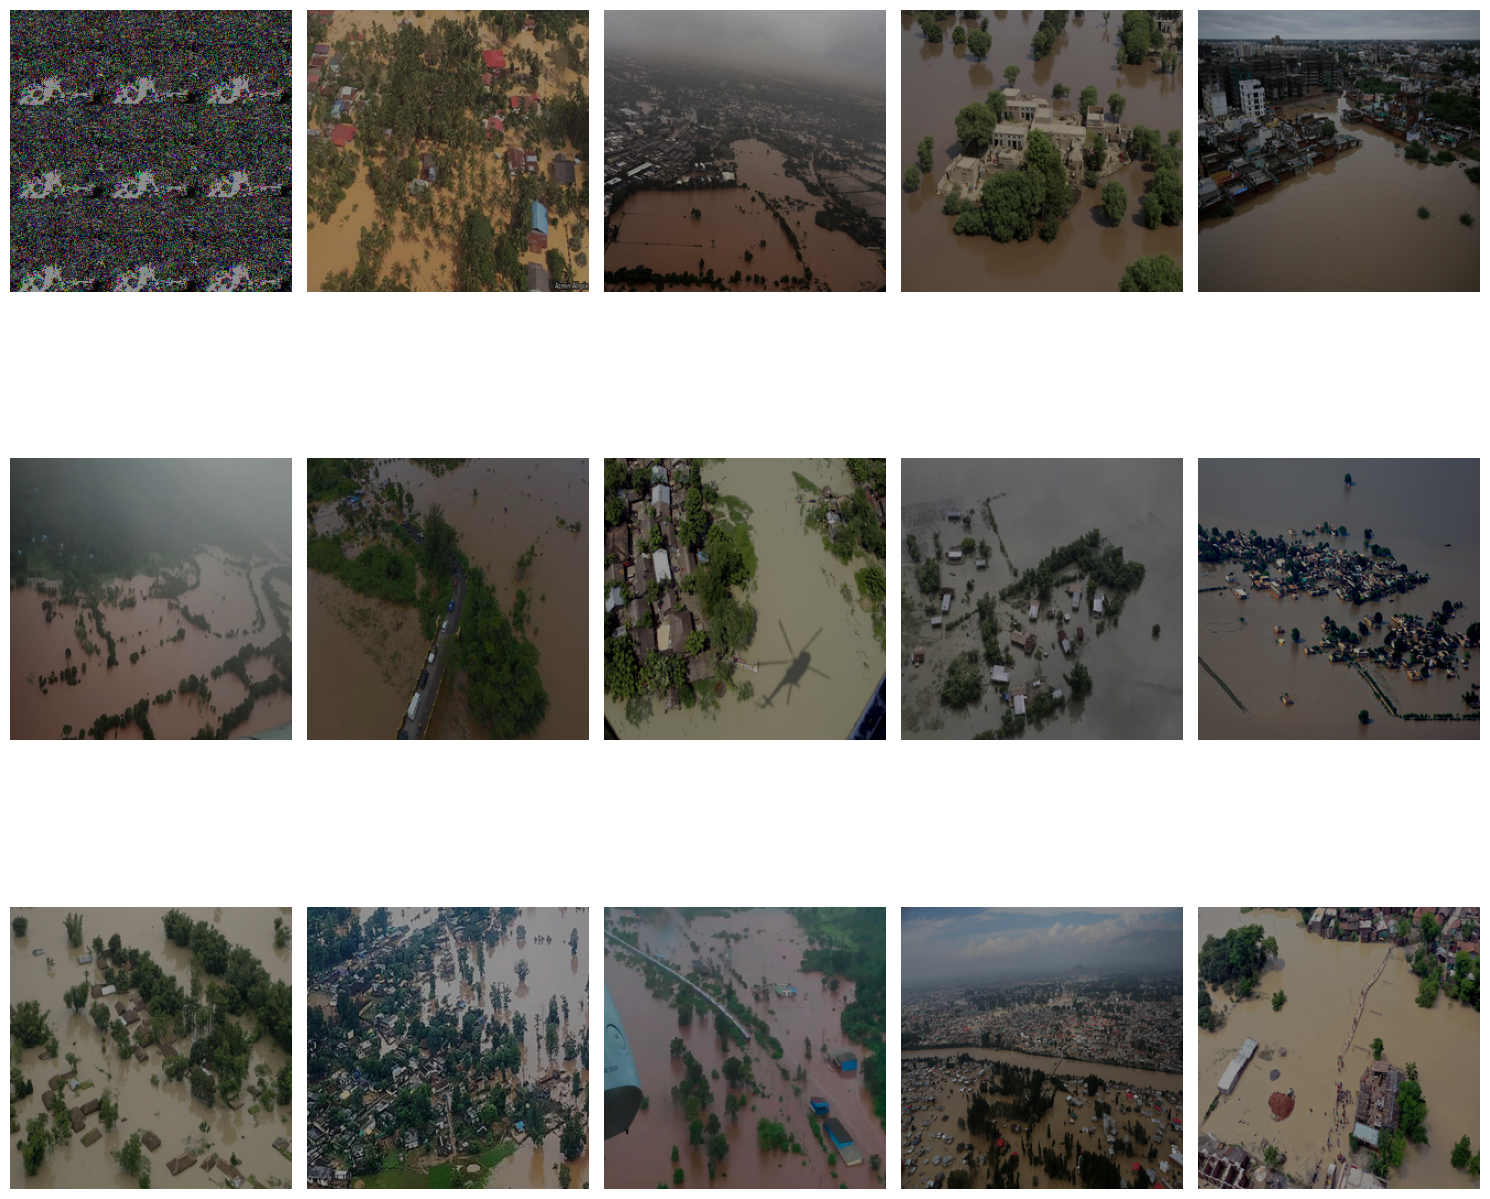

In [ ]:
def create_data(data_dir):
    """
    TODO: Traverse through the given data directory to extract and return paths to images and masks.
    - Identify relevant folders for images and masks.
    - Collect file paths from these folders and return them as lists.
    """
    images_dir = os.path.join(data_dir, 'Image')
    masks_dir = os.path.join(data_dir, 'Mask')

    image_paths = [os.path.join(images_dir, f) for f in os.listdir(
        images_dir) if f.endswith('.png') or f.endswith('.jpg')]
    mask_paths = [os.path.join(masks_dir, f) for f in os.listdir(
        masks_dir) if f.endswith('.png') or f.endswith('.jpg')]

    # ensure correct pairing
    image_paths.sort()
    mask_paths.sort()

    return image_paths, mask_paths


def load_image(image_path, SIZE):
    """
    TODO: Load and resize an individual image to the specified size, scaling pixel values appropriately.
    - Convert image to array and normalize pixel values.
    - Use resizing techniques to ensure uniform image dimensions.
    """
    image = Image.open(image_path)
    image = image.resize((SIZE, SIZE), PIL.Image.LANCZOS)
    image = np.array(image) / 255.0
    return image


def load_images(image_paths, SIZE, mask=False, trim=None):
    """
    TODO: Batch process a list of image paths, loading and organizing images into a numpy array.
    - Handle both image and mask files optionally, managing different channel dimensions.
    - Optionally trim the list of images to handle a subset of data.
    """
    images = []
    for i, path in enumerate(image_paths):
        if trim and i >= trim:
            break
        image = load_image(path, SIZE)

        # Ensure images have the correct shape
        if image.shape != (SIZE, SIZE, 3):
            # print(f"Warning: Image {path} has shape {image.shape}, resizing...")
            image = np.resize(image, (SIZE, SIZE, 3))

        if mask:
            # If it's a mask, ensure binary format (0 or 1 values)
            image = (image > 0.5).astype(np.uint8)  # Binarize the mask
        images.append(image)

    # Ensure all images have the same shape (handle different channels or dimensions)
    try:
        return np.array(images)
    except ValueError as e:
        print(f"Error when creating NumPy array: {e}")
        print(f"Shape of first image: {images[0].shape}")
        return np.array([])


def show_image(image, title=None, cmap=None, alpha=1):
    """
    TODO: Display a single image using matplotlib with options for color map and transparency.
    - Ensure axes are turned off for a cleaner display.
    - Include optional title for context.
    """
    plt.imshow(image, cmap=cmap)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()


def show_mask(image, mask, cmap=None, alpha=0.4):
    """
    TODO: Overlay a mask on an image to visualize segmentation results.
    - Use transparency to allow both mask and image to be visible.
    - Include color mapping to differentiate mask areas.
    """
    plt.imshow(image, cmap='gray')
    plt.imshow(mask, cmap=cmap, alpha=alpha)
    plt.axis('off')
    plt.show()


def show_images(imgs, msks, rows=3, cols=5):
    """
    TODO: Display multiple image-mask pairs to examine the dataset distribution.
    - Randomly select sample pairs of images and masks for visualization.
    - Use subplots to arrange visuals neatly and use tight layout for optimization.
    """
    fig, axs = plt.subplots(rows, cols, figsize=(15, 15))
    axs = axs.ravel()

    for i in range(min(rows * cols, len(imgs))):
        axs[i].imshow(imgs[i])
        if msks is not None and i < len(msks):
            axs[i].imshow(msks[i], alpha=0.4, cmap='jet')
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()


# TODO: Load and visualize images
data_dir = 'seg_archive'
SIZE = 256

image_paths, mask_paths = create_data('/content/drive/MyDrive/seg_archive')

images = load_images(image_paths, SIZE)
masks = load_images(mask_paths, SIZE, mask=True)

show_images(images, masks, rows=3, cols=5)

train_image_paths, val_image_paths, train_mask_paths, val_mask_paths = train_test_split(
    image_paths, mask_paths, test_size=0.2, random_state=42
)


class Dataset(Dataset):
    def __init__(self, img_paths, lbl_paths, transform=None):
        """
        Args:
            img_paths (list of str): List of file paths to the images.
            lbl_paths (list of str): List of file paths to the corresponding labels (masks).
            transform (callable, optional): Optional transform to be applied on an image-label pair.
        """
        self.img_paths = img_paths
        self.lbl_paths = lbl_paths
        self.transform = transform

    def __len__(self):
        """Returns the total number of images in the dataset."""
        return len(self.img_paths)

    def __getitem__(self, idx):
        """
        Args:
            idx (int): Index of the image-label pair to fetch.

        Returns:
            img (Tensor): Transformed image.
            lbl (Tensor): Transformed label (mask).
        """
        # Load the image and label (mask)
        img = load_image(self.img_paths[idx], SIZE)
        lbl = load_image(self.lbl_paths[idx], SIZE)

        # Ensure images are in RGB format (3 channels)
        if len(img.shape) == 2:  # Grayscale, replicate channels to create RGB
            img = np.stack([img] * 3, axis=-1)
        elif img.shape[-1] == 4:  # RGBA, discard alpha channel
            img = img[:, :, :3]

        # Ensure the label (mask) has 1 channel (in case it has multiple channels)
        if len(lbl.shape) == 3:  # If the label has multiple channels, reduce to 1
            lbl = lbl[:, :, 0]

        # Apply transforms if provided
        if self.transform:
            img = self.transform(img)
            lbl = self.transform(lbl)
        else:
            # Convert to torch tensors and reorder the channels (HWC -> CHW for image)
            img = torch.tensor(img.transpose((2, 0, 1)), dtype=torch.float32)
            lbl = torch.tensor(lbl, dtype=torch.float32).unsqueeze(
                0)  # Add channel dimension for label

        return img, lbl


# Dataset and dataloader setup
train_dataset = Dataset(
    train_image_paths, train_mask_paths, transform=ToTensor())
valid_dataset = Dataset(
    val_image_paths, val_mask_paths, transform=ToTensor())

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)

## The Architecture
In addition to U-Net, we are going to utilize Attention Gates.
You probably need to read this paper: https://arxiv.org/pdf/1804.03999v3

In [ ]:
class DiceLoss(nn.Module):
    def __init__(self, epsilon=1e-6):
        super(DiceLoss, self).__init__()
        self.epsilon = epsilon

    def forward(self, prediction, ground_truth):
        """
        Calculate Dice loss for segmentation predictions.
        - prediction: model's output probabilities
        - ground_truth: binary ground truth masks
        """
        intersection = torch.sum(prediction * ground_truth)
        total = torch.sum(prediction) + torch.sum(ground_truth)
        dice_score = (2.0 * intersection + self.epsilon) / (total + self.epsilon)
        return 1 - dice_score


class JaccardLoss(nn.Module):
    def __init__(self, epsilon=1e-6):
        super(JaccardLoss, self).__init__()
        self.epsilon = epsilon

    def forward(self, prediction, ground_truth):
        """
        Compute Jaccard loss (IoU) for segmentation tasks.
        - prediction: model-generated probability map
        - ground_truth: actual binary masks
        """
        intersection = torch.sum(prediction * ground_truth)
        union = torch.sum(prediction) + torch.sum(ground_truth) - intersection
        jaccard_score = (intersection + self.epsilon) / (union + self.epsilon)
        return 1 - jaccard_score


class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_rate, use_pooling=True):
        super(EncoderBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU()
        self.dropout_layer = nn.Dropout(dropout_rate)
        self.use_pooling = use_pooling

        if use_pooling:
            self.pool = nn.MaxPool2d(kernel_size=2)

    def forward(self, input_tensor):
        input_tensor = self.activation(self.batch_norm1(self.conv1(input_tensor)))
        input_tensor = self.activation(self.batch_norm2(self.conv2(input_tensor)))
        input_tensor = self.dropout_layer(input_tensor)
        if self.use_pooling:
            input_tensor = self.pool(input_tensor)
        return input_tensor


class DecoderBlock(nn.Module):
    def __init__(self, in_channels, filter_count, dropout_rate):
        super(DecoderBlock, self).__init__()
        self.up_conv = nn.ConvTranspose2d(in_channels, filter_count, kernel_size=2, stride=2)

        self.conv1 = nn.Conv2d(filter_count + filter_count, filter_count, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(filter_count, filter_count, kernel_size=3, padding=1)
        self.batch_norm1 = nn.BatchNorm2d(filter_count)
        self.batch_norm2 = nn.BatchNorm2d(filter_count)
        self.activation = nn.ReLU()
        self.dropout_layer = nn.Dropout(dropout_rate)

    def forward(self, input_tensor, skip_tensor):
        input_tensor = self.up_conv(input_tensor)
        input_tensor = F.interpolate(input_tensor, size=skip_tensor.shape[2:], mode="bilinear", align_corners=False)
        input_tensor = torch.cat([input_tensor, skip_tensor], dim=1)
        input_tensor = self.activation(self.batch_norm1(self.conv1(input_tensor)))
        input_tensor = self.activation(self.batch_norm2(self.conv2(input_tensor)))
        input_tensor = self.dropout_layer(input_tensor)
        return input_tensor


class AttentionGate(nn.Module):
    def __init__(self, filter_count, apply_bn):
        super(AttentionGate, self).__init__()
        self.apply_bn = apply_bn

        self.conv_x = nn.Sequential(
            nn.Conv2d(filter_count, filter_count, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(filter_count) if apply_bn else nn.Identity()
        )

        self.psi = nn.Sequential(
            nn.Conv2d(filter_count, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1) if apply_bn else nn.Identity(),
            nn.Sigmoid()
        )

        self.activation = nn.ReLU(inplace=True)

    def forward(self, input_tensor):
        processed_x = self.conv_x(input_tensor)
        if processed_x.shape != input_tensor.shape:
            processed_x = F.interpolate(processed_x, size=input_tensor.shape[2:], mode="bilinear", align_corners=True)
        attention_map = self.psi(self.activation(processed_x))
        output_tensor = input_tensor * attention_map
        return output_tensor


class UNetModel(nn.Module):
    def __init__(self):
        super(UNetModel, self).__init__()
        self.encoder1 = EncoderBlock(in_channels=3, out_channels=64, dropout_rate=0.1, use_pooling=True)
        self.encoder2 = EncoderBlock(in_channels=64, out_channels=128, dropout_rate=0.1, use_pooling=True)
        self.encoder3 = EncoderBlock(in_channels=128, out_channels=256, dropout_rate=0.1, use_pooling=True)
        self.encoder4 = EncoderBlock(in_channels=256, out_channels=512, dropout_rate=0.1, use_pooling=True)
        self.bottleneck = EncoderBlock(in_channels=512, out_channels=1024, dropout_rate=0.1, use_pooling=False)
        self.decoder4 = DecoderBlock(in_channels=1024, filter_count=512, dropout_rate=0.1)
        self.decoder3 = DecoderBlock(in_channels=512, filter_count=256, dropout_rate=0.1)
        self.decoder2 = DecoderBlock(in_channels=256, filter_count=128, dropout_rate=0.1)
        self.decoder1 = DecoderBlock(in_channels=128, filter_count=64, dropout_rate=0.1)

        self.attention4 = AttentionGate(filter_count=512, apply_bn=True)
        self.attention3 = AttentionGate(filter_count=256, apply_bn=True)
        self.attention2 = AttentionGate(filter_count=128, apply_bn=True)
        self.attention1 = AttentionGate(filter_count=64, apply_bn=True)

        self.output_conv = nn.Conv2d(64, 1, kernel_size=1, stride=1, padding=0)

    def forward(self, input_tensor):
        enc1 = self.encoder1(input_tensor)
        enc2 = self.encoder2(enc1)
        enc3 = self.encoder3(enc2)
        enc4 = self.encoder4(enc3)

        bottleneck_out = self.bottleneck(enc4)

        dec4 = self.decoder4(bottleneck_out, self.attention4(enc4))
        dec3 = self.decoder3(dec4, self.attention3(enc3))
        dec2 = self.decoder2(dec3, self.attention2(enc2))
        dec1 = self.decoder1(dec2, self.attention1(enc1))

        segmentation_output = torch.sigmoid(self.output_conv(dec1))
        return segmentation_output

    def compute_loss(self, prediction, ground_truth):
        """
        Compute combined segmentation loss using Dice and Jaccard metrics.
        - prediction: predicted probability maps
        - ground_truth: true probability maps
        """
        dice_loss = DiceLoss()(prediction, ground_truth)
        jaccard_loss = JaccardLoss()(prediction, ground_truth)
        return dice_loss + jaccard_loss


# Model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNetModel().to(device)

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)



## Training

In [ ]:
# TODOL:
# set batch size for training
# number of all epochs in training
# number of epochs to run before asking if you want to halt training


# Training

device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_epochs = 50  # Set the desired number of epochs
check_interval = 5  # Ask after every 5 epochs


def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    epoch_loss = 0
    correct_predictions = 0
    total_samples = 0

    for batch_idx, (images, masks) in enumerate(train_loader):
        images, masks = images.float().to(device), masks.float().to(device)

        # Forward pass
        outputs = model(images)

        # Match output size to mask size
        if outputs.size() != masks.size():
            outputs = F.interpolate(outputs, size=masks.size()[
                                    2:], mode='bilinear', align_corners=False)

        # Calculate loss
        loss = criterion(outputs, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        # Calculate accuracy
        preds = (outputs > 0.5).float()
        correct_predictions += (preds == masks).sum().item()
        total_samples += masks.numel()

    avg_loss = epoch_loss / len(train_loader)
    accuracy = correct_predictions / total_samples
    return avg_loss, accuracy


def validate_one_epoch(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.float().to(device), masks.float().to(device)

            # Forward pass
            outputs = model(images)

            # Match output size to mask size
            if outputs.size() != masks.size():
                outputs = F.interpolate(outputs, size=masks.size()[
                                        2:], mode='bilinear', align_corners=False)

            # Calculate loss
            loss = criterion(outputs, masks)
            val_loss += loss.item()

            # Calculate accuracy
            preds = (outputs > 0.5).float()
            correct_predictions += (preds == masks).sum().item()
            total_samples += masks.numel()

    avg_loss = val_loss / len(val_loader)
    accuracy = correct_predictions / total_samples
    return avg_loss, accuracy


def train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    # Initialize lists to store the losses and accuracies
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    for epoch in range(num_epochs):
        # Train for one epoch
        train_loss, train_accuracy = train_one_epoch(
            model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validate after each epoch
        val_loss, val_accuracy = validate_one_epoch(
            model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Print progress
        print(f"Epoch [{epoch + 1}/{num_epochs}], "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

    return train_losses, train_accuracies, val_losses, val_accuracies


train_losses, train_accuracies, val_losses, val_accuracies = train_and_validate(
    model, train_loader, valid_loader, nn.BCEWithLogitsLoss(), optimizer, n_epochs, device
)

Epoch [1/50], Train Loss: 0.6705, Train Acc: 0.7392, Val Loss: 0.9028, Val Acc: 0.3560
Epoch [2/50], Train Loss: 0.6424, Train Acc: 0.7715, Val Loss: 0.8435, Val Acc: 0.3959
Epoch [3/50], Train Loss: 0.6294, Train Acc: 0.7848, Val Loss: 0.7255, Val Acc: 0.6434
Epoch [4/50], Train Loss: 0.6197, Train Acc: 0.7908, Val Loss: 0.6429, Val Acc: 0.7456
Epoch [5/50], Train Loss: 0.6168, Train Acc: 0.7930, Val Loss: 0.6228, Val Acc: 0.7867
Epoch [6/50], Train Loss: 0.6090, Train Acc: 0.7985, Val Loss: 0.6309, Val Acc: 0.7871
Epoch [7/50], Train Loss: 0.6072, Train Acc: 0.7984, Val Loss: 0.6201, Val Acc: 0.7772
Epoch [8/50], Train Loss: 0.6036, Train Acc: 0.8045, Val Loss: 0.6161, Val Acc: 0.8018
Epoch [9/50], Train Loss: 0.6011, Train Acc: 0.8080, Val Loss: 0.6162, Val Acc: 0.7994
Epoch [10/50], Train Loss: 0.5968, Train Acc: 0.8170, Val Loss: 0.6404, Val Acc: 0.7658
Epoch [11/50], Train Loss: 0.5984, Train Acc: 0.8115, Val Loss: 0.6248, Val Acc: 0.7904
Epoch [12/50], Train Loss: 0.5981, Train 

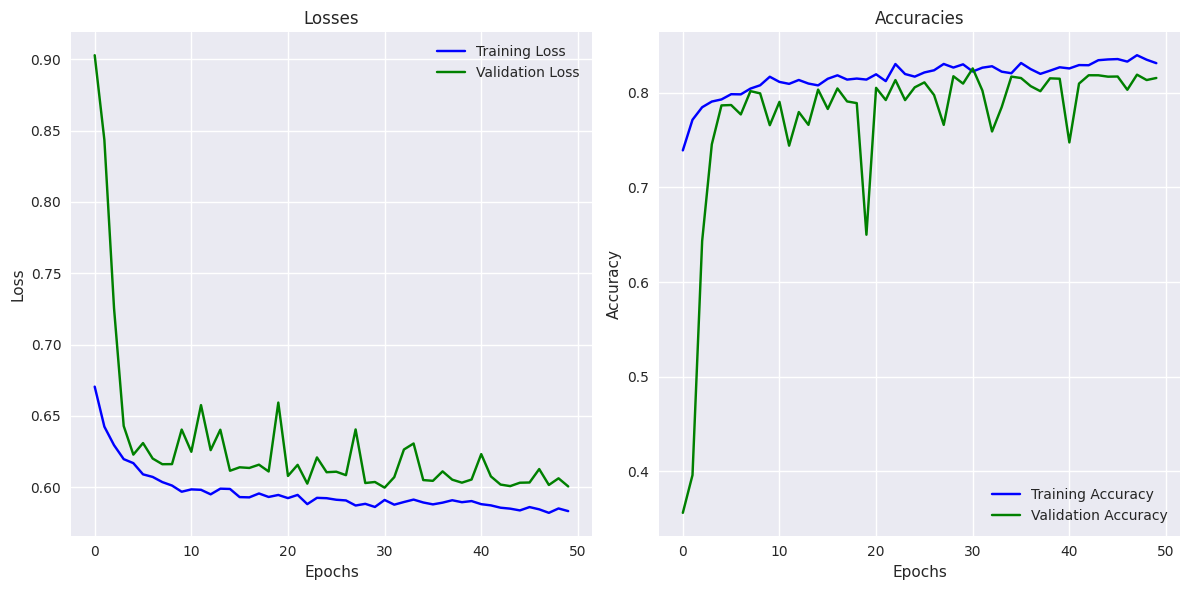

In [ ]:
# TODO: Plot training and validation losses and accuracies

plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='green')
plt.title('Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy', color='blue')
plt.plot(val_accuracies, label='Validation Accuracy', color='green')
plt.title('Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Plottings

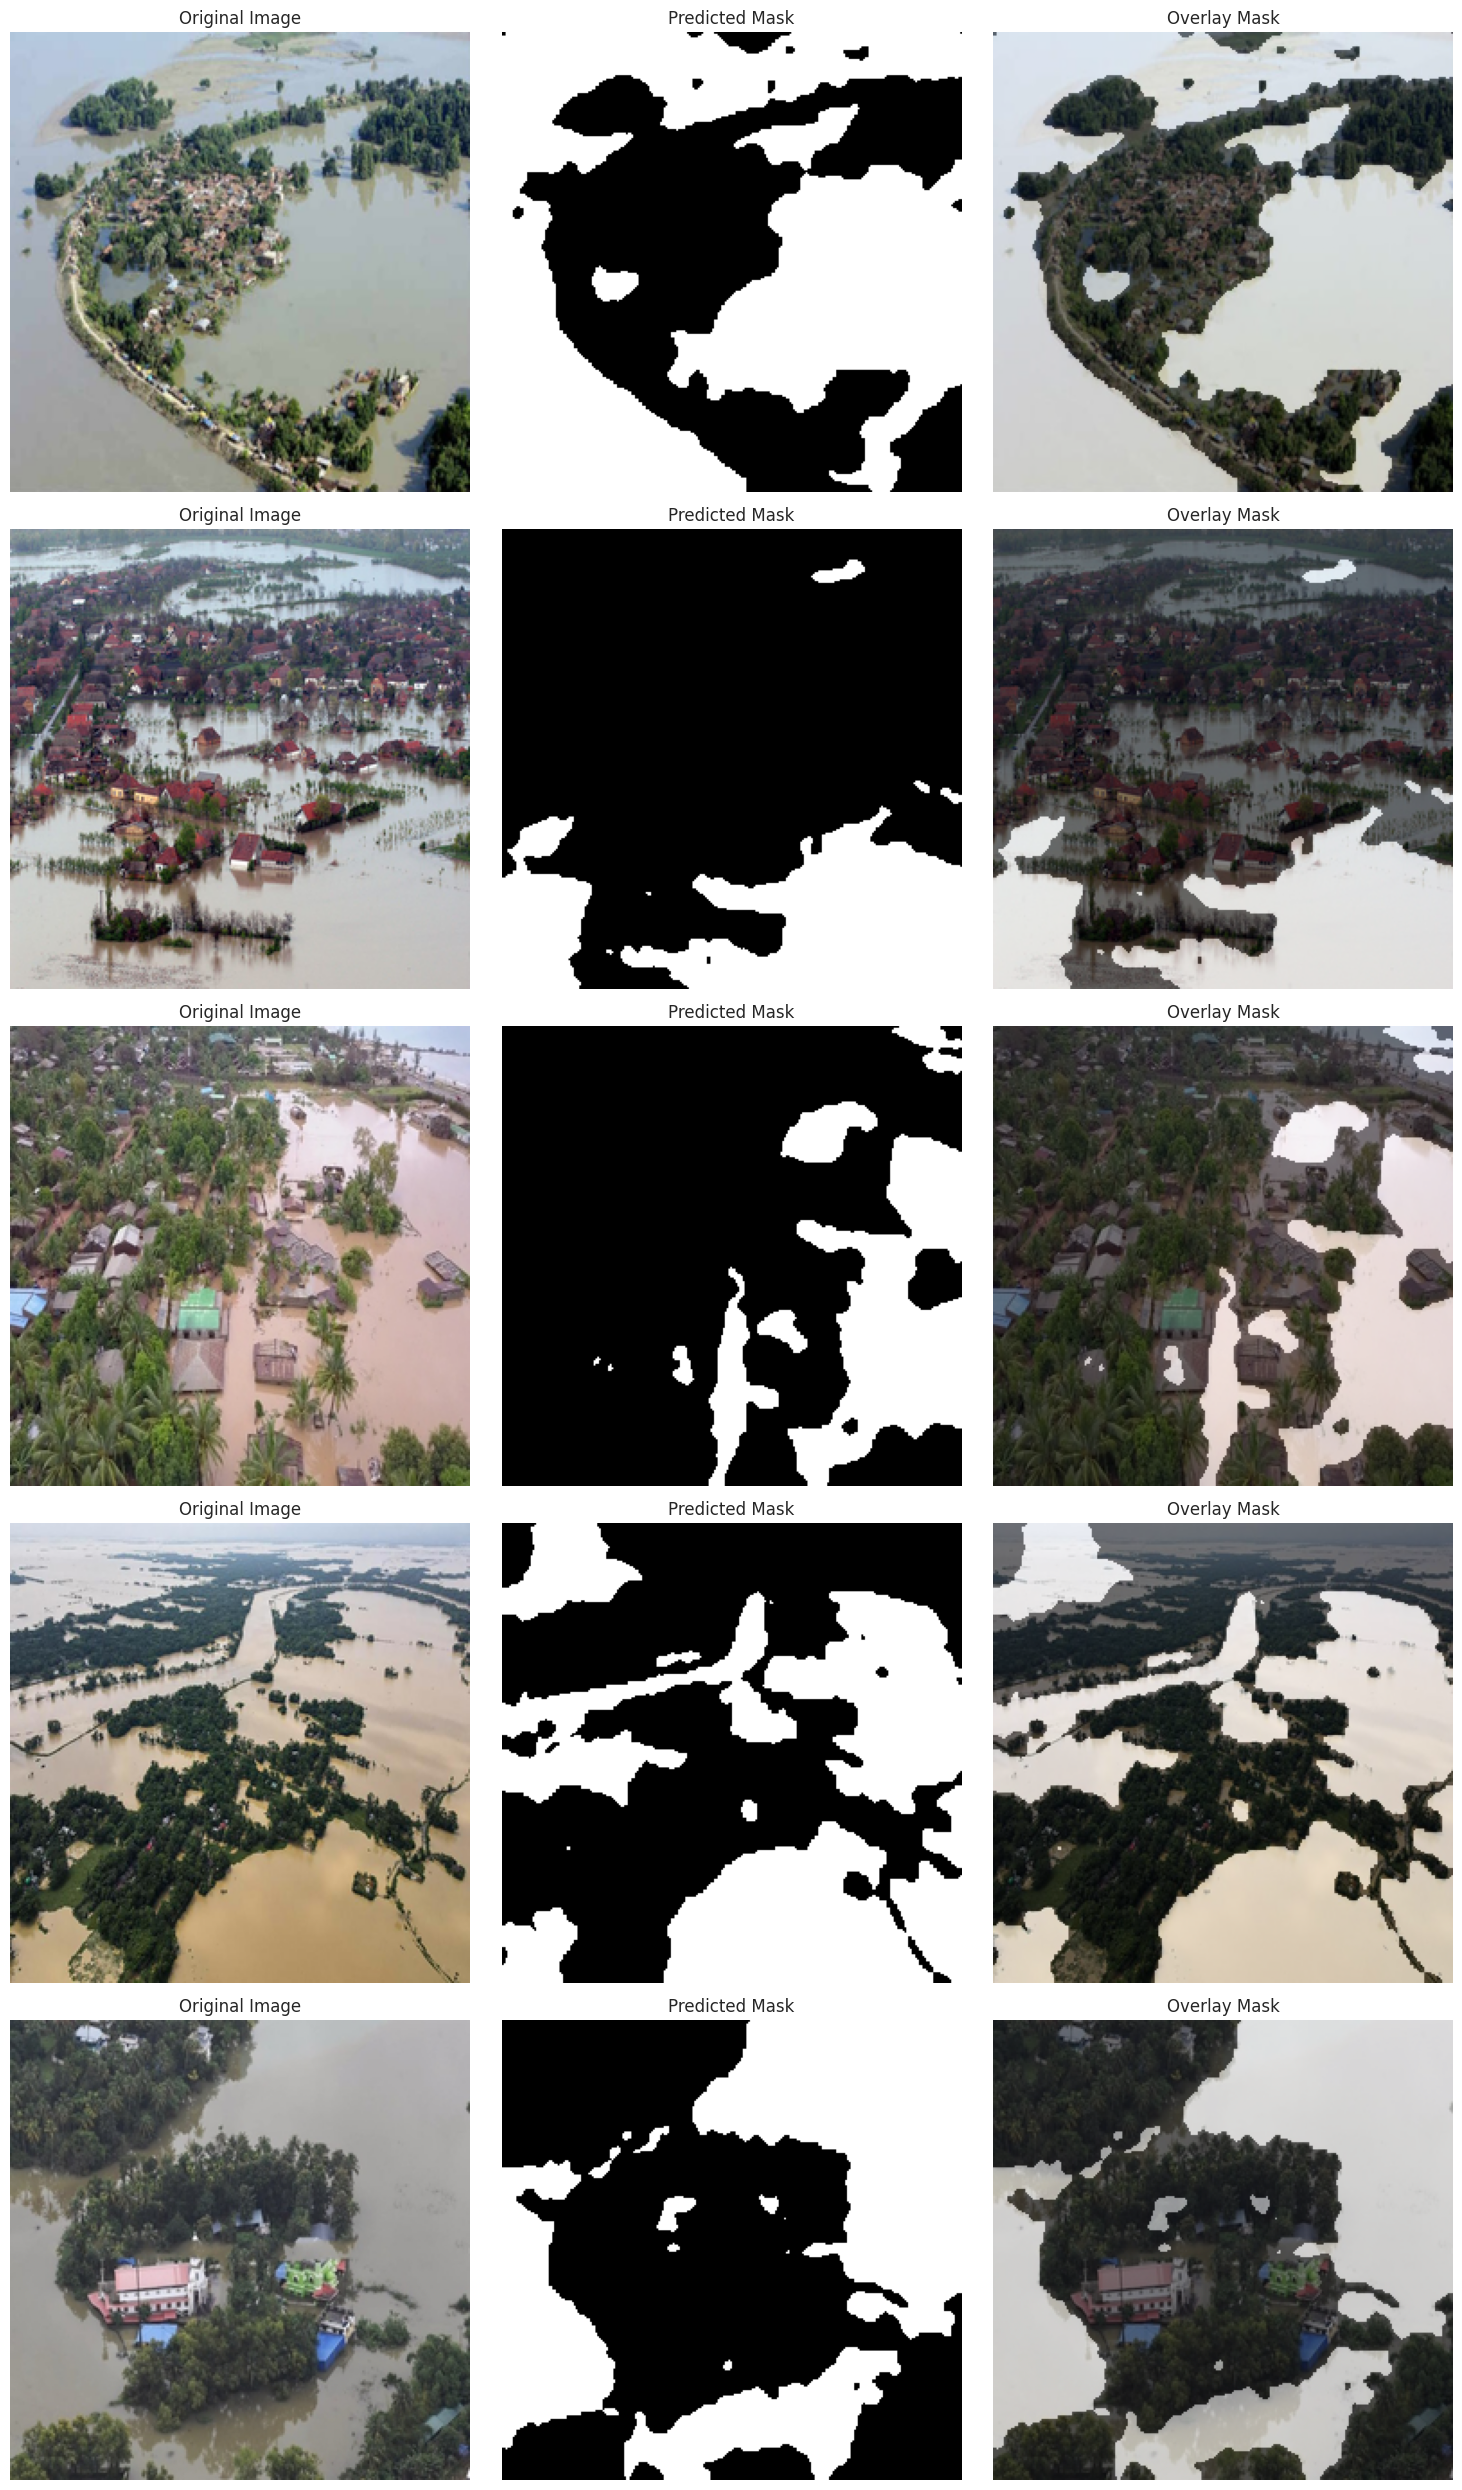

In [ ]:
# Plot the original mask, the one you predicted, and the final one using a threshold

import random
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import numpy as np

def plot_images(model, dataset, num_samples=5, threshold=0.5, alpha=0.5):

    model.eval()  # Set model to evaluation mode
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))

    for idx in range(num_samples):
        sample_idx = random.randint(0, len(dataset) - 1)
        image, original_mask = dataset[sample_idx]

        image = preprocess_image(image, device)
        original_mask = original_mask.to(device).float()

        predicted_mask = predict_mask(model, image)
        predicted_mask = resize_mask(predicted_mask, original_mask)

        binary_mask = threshold_mask(predicted_mask, threshold)
        processed_mask = create_overlay(binary_mask)

        display_images(axes, idx, image, binary_mask, processed_mask, alpha)

    plt.tight_layout()
    plt.show()

def preprocess_image(image, device):
    image = image.to(device).float().unsqueeze(0)  # Add batch dimension
    return image

def predict_mask(model, image):
    with torch.no_grad():
        predicted_mask = model(image)
    return predicted_mask

def resize_mask(predicted_mask, original_mask):
    if predicted_mask.size(2) != original_mask.size(1) or predicted_mask.size(3) != original_mask.size(2):
        predicted_mask = F.interpolate(predicted_mask, size=(original_mask.size(1), original_mask.size(2)),
                                       mode='bilinear', align_corners=False)
    return predicted_mask.squeeze(0).squeeze(0).cpu().numpy()  # Remove batch and channel dimensions

def threshold_mask(predicted_mask, threshold):
    return (predicted_mask > threshold).astype(np.float32)

def create_overlay(binary_mask):
    return np.stack([binary_mask] * 3, axis=-1)  # Convert to 3-channel

def display_images(axes, idx, image, binary_mask, processed_mask, alpha):
    """Display the original image, predicted mask, and overlay mask."""
    # Convert image to numpy for plotting
    image = image.squeeze().permute(1, 2, 0).cpu().numpy()  # Convert CHW to HWC

    # Plot original image
    axes[idx, 0].imshow(image)
    axes[idx, 0].set_title("Original Image")
    axes[idx, 0].axis("off")

    # Plot predicted mask
    axes[idx, 1].imshow(binary_mask, cmap="gray")
    axes[idx, 1].set_title("Predicted Mask")
    axes[idx, 1].axis("off")

    # Plot processed mask on image
    blended = (1 - alpha) * image + alpha * processed_mask
    axes[idx, 2].imshow(blended)
    axes[idx, 2].set_title("Processed Mask")
    axes[idx, 2].axis("off")


plot_images(model, valid_dataset, num_samples=5, threshold=0.5, alpha=0.5)

1. **Comparison with Conventional Loss Functions**:
    - How do Dice and Jaccard Losses differ from Cross-Entropy or Mean Squared Error, particularly in terms of sensitivity to class imbalances?
    - What advantages do these losses offer in capturing the spatial overlap between the predicted and true segmentations?<br/><br/>
    
    
            Cross-Entropy Loss:

            Measures the probability of assigning the correct class, treating all pixels equally.
            Highly sensitive to class imbalance. In segmentation tasks with large background areas, the model tends to predict the dominant class (e.g., background) more often, leading to poor performance on smaller, less frequent classes.
            Requires weighting schemes or other adjustments (e.g., focal loss) to mitigate this issue.

            Mean Squared Error (MSE):

            Measures pixel-wise differences between predicted and target probabilities.
            Does not consider class imbalance explicitly and is not well-suited for segmentation tasks where spatial relationships and overlap are critical.
            Can lead to over-smoothing in boundary regions.

            Dice and Jaccard Losses:

            Directly optimize for spatial overlap between predicted and true regions.
            Focus on the intersection (overlap) of predictions and ground truth, making them inherently more robust to class imbalance.
            Small structures and less frequent classes contribute proportionally to the loss, as they impact the overlap metric directly.
            Dice loss emphasizes the balance between precision and recall, while Jaccard loss minimizes over-prediction and under-prediction errors.

2. **Interpretation of Loss Values**:
    - Discuss what high or low loss scores reveal about the state and effectiveness of your segmentation model.<br/><br/>

        High Score:<br/><br/>

            Indicate poor alignment between predicted and true segmentations.
            Common causes:

            Model underfitting: The model has not learned meaningful patterns (e.g., during early training epochs).
            Class imbalance: The model might over-predict dominant classes (e.g., background) or ignore smaller classes.
            Poor boundary adherence: The model fails to capture fine-grained details or segment boundaries accurately.
            Noisy data or incorrect labels: Misaligned or mislabeled ground truths may lead to inflated losses.

        Low Score:<br/><br/>
    
            Suggest good overlap and alignment between predictions and ground truth.
            Indicate that the model captures the essential features and boundaries effectively, with minimal false positives or false negatives.
            Caveats:

            A very low loss may indicate overfitting, where the model memorizes the training data without generalizing well to unseen data.
            For class imbalance, low loss might still obscure performance if the metric is dominated by easy-to-predict classes (e.g., background).

Evaluate the role of the attention mechanism in optimizing segmentation accuracy in cluttered environments. How does it refine the segmentation process?<br/><br/>

    Attention mechanisms enhance segmentation accuracy in cluttered environments by focusing on the most relevant spatial and contextual features, addressing challenges like complex backgrounds, overlapping objects, and spatial variability.

They refine segmentation by:

    Selective Focus: Prioritizing critical regions and suppressing irrelevant noise.
    Boundary Refinement: Enhancing edge detection and reducing over-smoothing.
    Multi-Scale Context: Capturing hierarchical details for better object representation.
    Noise Reduction: Ignoring distractors in cluttered scenes.

    Key mechanisms include spatial attention (highlighting regions), channel attention (weighing feature importance), and self-attention (capturing global relationships). These approaches improve object localization, boundary precision, and generalization, making attention indispensable in domains like medical imaging, autonomous vehicles, and aerial image analysis.

What is the importance of skip connections in U-Net, and how do they enhance the accuracy of segmentation tasks?<br/><br/>

    Skip connections are vital in U-Net as they bridge the encoder and decoder, preserving spatial details and enabling multi-scale learning. They enhance segmentation accuracy by:

    Retaining fine-grained spatial information.
    Improving boundary delineation.
    Facilitating better gradient flow during training.
    Reconstructing high-resolution outputs effectively.

    By combining low-level and high-level features, skip connections make U-Net highly effective for tasks requiring precise segmentation and localization.

Explain the difference between the predicted and processed mask above.<br/><br/>

    Predicted Mask: Provides a probabilistic understanding that can be used for further refinement or confidence estimation.<br/>
    Processed Mask: Represents the final segmentation result, used for evaluation, visualization, and real-world applications.